# 02 - Cell Type Annotation

This notebook demonstrates clustering and cell type annotation for single-cell data.

## Overview

Steps include:
1. Load preprocessed data
2. Neighbor graph construction
3. Clustering (Leiden algorithm)
4. UMAP visualization
5. Marker gene identification
6. Cell type annotation

## Setup

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Set working directory to notebook location
notebook_dir = r'z:\thornes\Pavlicev_lab_rotation\FLUXestimator\notebooks'
os.chdir(notebook_dir)
print(f"Working directory: {os.getcwd()}")

# Configure scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', figsize=(10, 10))

print(f"Scanpy version: {sc.__version__}")

Working directory: z:\thornes\Pavlicev_lab_rotation\FLUXestimator\notebooks
Scanpy version: 1.11.5


C:\Users\dell\AppData\Local\Temp\ipykernel_22040\812040750.py:18: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


## Load Configuration and Data

In [2]:
# Load configuration
with open('../config/analysis_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [3]:
# Load preprocessed data
adata = sc.read_h5ad('../data/processed/preprocessed_data.h5ad')

print(f"Loaded data: {adata.shape[0]} cells x {adata.shape[1]} genes")
adata

# Get normalized log-transformed expression as DataFrame
expr_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
    index=adata.obs_names,  # Cell barcodes as rows
    columns=adata.var_names  # Gene names as columns
)

# Display first few rows and columns
print(f"Expression matrix shape: {expr_df.shape}")
print(f"Cells: {expr_df.shape[0]}, Genes: {expr_df.shape[1]}")

#trasnpose matrix to have gees as rows and cells as columns
expr_df_transposed = expr_df.T

# Save to CSV
expr_df_transposed.to_csv('../data/processed/expression_matrix.csv')
print("Expression matrix saved to '../data/processed/expression_matrix.csv'")
expr_df_transposed.iloc[:5, :5]  # Display first 5 genes and 5 cells


Loaded data: 7840 cells x 23542 genes
Expression matrix shape: (7840, 23542)
Cells: 7840, Genes: 23542
Expression matrix saved to '../data/processed/expression_matrix.csv'


,AAACCCAAGGGTGAAA-1,AAACCCAAGTTTCAGC-1,AAACCCACAAACTAAG-1,AAACCCACAGAAACCG-1,AAACCCACAGGTTTAC-1
Xkr4,0.144675,-0.461820,-0.461820,0.826299,-0.461820
Gm1992,-0.099421,-0.099421,-0.099421,-0.099421,-0.099421
Gm19938,3.113390,-0.173627,-0.173627,-0.173627,-0.173627
Gm37381,-0.024974,-0.024974,-0.024974,-0.024974,-0.024974
Rp1,-0.046218,-0.046218,-0.046218,-0.046218,-0.046218


## Neighborhood Graph

Construct k-nearest neighbor graph in PCA space.

In [4]:
# Compute neighborhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=config['cell_annotation']['n_neighbors'],
    n_pcs=config['cell_annotation']['n_pcs']
)

print("Neighborhood graph computed")

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
Neighborhood graph computed


## Clustering

Apply Leiden clustering algorithm.

In [5]:
# Leiden clustering
sc.tl.leiden(
    adata,
    # resolution=config['cell_annotation']['resolution'],
    resolution=0.8,
    random_state=config['compute']['random_state']
)

print(f"Identified {adata.obs['leiden'].nunique()} clusters")
print(adata.obs['leiden'].value_counts().sort_index())

# for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
#     sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
#     print(f"Resolution {res}: {adata.obs[f'leiden_{res}'].nunique()} clusters")

running Leiden clustering


C:\Users\dell\AppData\Local\Temp\ipykernel_22040\3066720137.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
Identified 21 clusters
leiden
0     1468
1      986
2      960
3      748
4      572
5      477
6      417
7      364
8      364
9      260
10     229
11     201
12     200
13     173
14     140
15     108
16      45
17      44
18      39
19      30
20      15
Name: count, dtype: int64


## UMAP Visualization

Compute UMAP embedding for visualization.

In [9]:
# Compute UMAP
sc.tl.umap(
    adata,
    min_dist=config['visualization']['umap_min_dist'],
    spread=config['visualization']['umap_spread'],
    random_state=config['compute']['random_state']
)

print("UMAP embedding computed")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
UMAP embedding computed


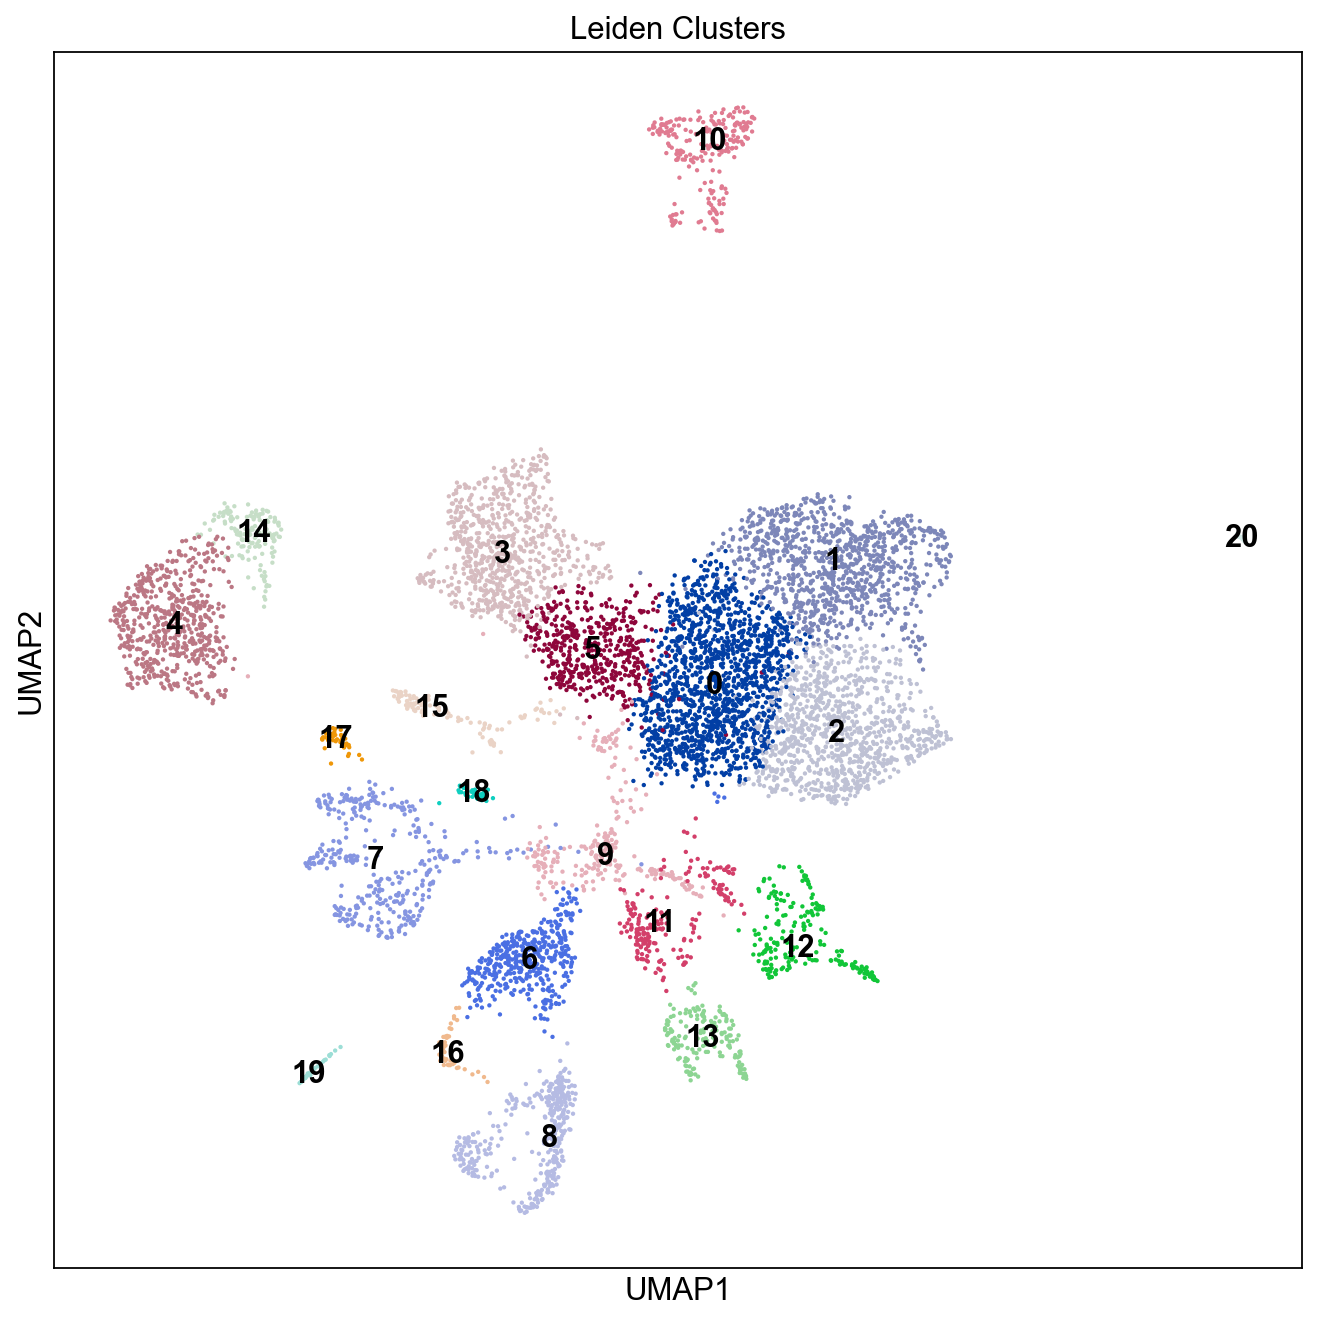

In [10]:
# Visualize clusters
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='Leiden Clusters')

## Marker Gene Identification

Find differentially expressed genes for each cluster.

In [11]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Find marker genes for each cluster
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    key_added='rank_genes'
)

print("Marker gene analysis complete")

ranking genes
    finished: added to `.uns['rank_genes']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:46)
Marker gene analysis complete


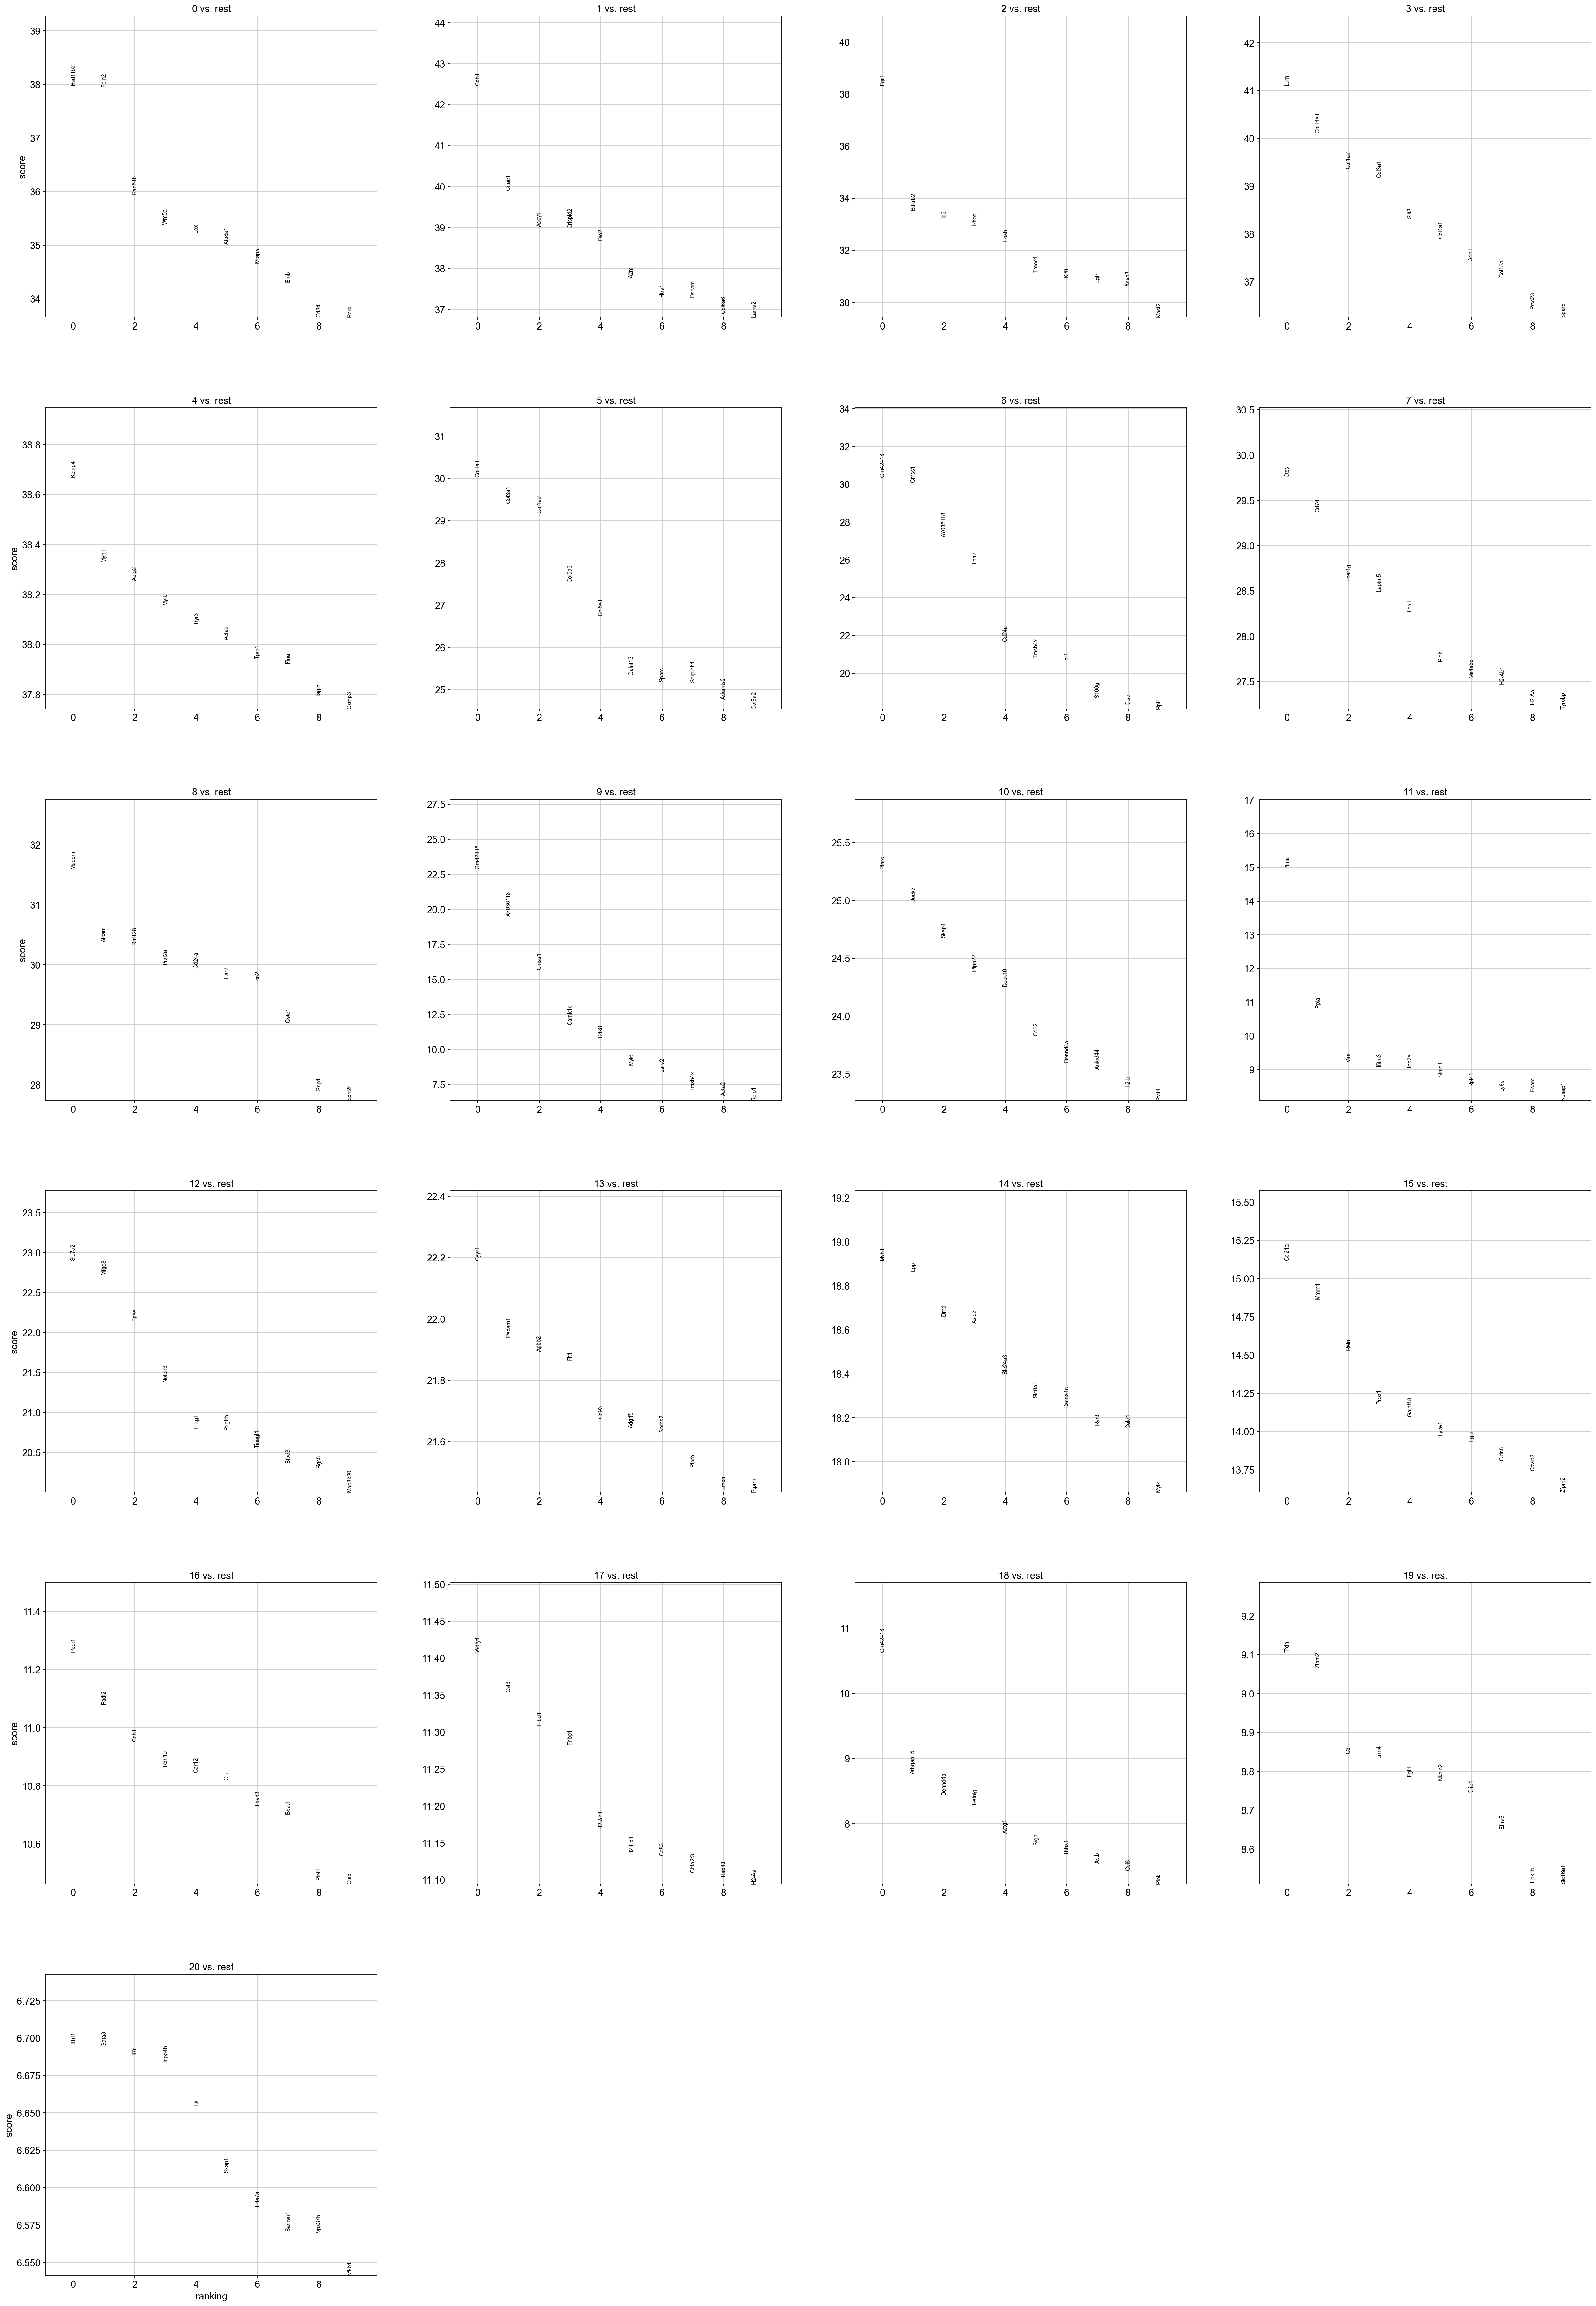

In [12]:
# Visualize top marker genes
sc.pl.rank_genes_groups(adata, n_genes=10, key='rank_genes', sharey=False)

In [13]:
# Get top marker genes as dataframe
marker_df = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes')
# save matrix
marker_df.to_csv('../results/tables/marker_genes.csv', index=False)
marker_df.head(20)

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,Hsd11b2,37.979408,NaN,0.000000e+00,0.000000e+00
1,0,Fbln2,37.954639,NaN,0.000000e+00,0.000000e+00
2,0,Rad51b,35.948181,NaN,5.403806e-283,4.240547e-279
3,0,Wnt5a,35.388588,NaN,2.558121e-274,1.505582e-270
4,0,Lox,35.231739,NaN,6.533334e-272,3.076155e-268
5,0,Atp8a1,35.013851,NaN,1.384871e-268,5.433773e-265
6,0,Mfap5,34.670490,NaN,2.194533e-263,7.380529e-260
7,0,Emb,34.310223,NaN,5.524112e-258,1.625608e-254
8,0,Cd34,33.660213,NaN,2.210402e-248,5.781920e-245
9,0,Rorb,33.655689,NaN,2.574091e-248,6.059926e-245


## Cell Type Annotation

Annotate clusters based on known marker genes.

Showing marker genes for clusters: 6, 9, 11
Cells in subset: 878


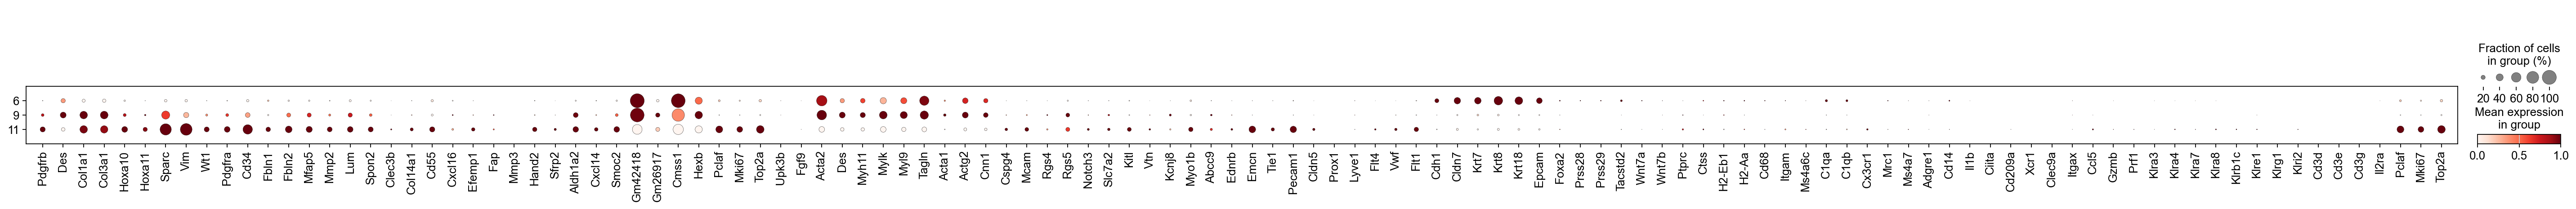

In [ ]:
# Define marker genes for reproductive tissue cell types
marker_genes = config['cell_annotation']['marker_genes']

# Visualize marker gene expression
all_markers = [gene for genes in marker_genes.values() for gene in genes]
available_markers = [g for g in all_markers if g in adata.var_names]

if len(available_markers) > 0:
    sc.pl.dotplot(
        adata,
        var_names=available_markers[:150],  # Show first 150 available markers
        groupby='leiden',
        standard_scale='var'
    )
else:
    print("Note: Marker genes not found in dataset.")

In [25]:
# Manual annotation based on marker gene expression

cluster_annotations = {
    '0': 'Fibroblast Cells',
    '1': 'Fibroblast Cells',
    '2': 'Inner Fibroblast Cells',
    '3': 'Fibroblasts: Clec3b+ (outer/basal)',
    '4': 'Myometrium: Smooth Muscle Cells',
    '5': 'Fibroblast Cells',
    '6': 'Epithelial Cells',
    '7': 'Macrophage Cells',
    '8': 'Luminal Epithelial Cells',
    '9': 'Ignore',
    '10': 'Natural Killer Cells',
    '11': 'Inconclusive',
    '12': 'Perivascular/Mural Cells',
    '13': 'Vascular Endothelial Cells',
    '14': 'Myometrium: Perivascular/Muscle Cells',
    '15': 'Lymphatic Endothelial Cells',
    '16': 'Glandular Epithelial Cells',
    '17': 'Dendritic Monocyte Cells',
    '18': 'Immune Cells',
    '19': 'Mesothelial Cells',
    '20': 'T Cells'
}

# Map cluster IDs to cell type names
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)

# For unmapped clusters, keep cluster ID
adata.obs['cell_type'] = adata.obs['cell_type'].fillna('Cluster ' + adata.obs['leiden'].astype(str))

print("Cell type annotations:")
print(adata.obs['cell_type'].value_counts())

Cell type annotations:
cell_type
Fibroblast Cells                         2931
Inner Fibroblast Cells                    960
Fibroblasts: Clec3b+ (outer/basal)        748
Myometrium: Smooth Muscle Cells           572
Epithelial Cells                          417
Luminal Epithelial Cells                  364
Macrophage Cells                          364
Ignore                                    260
Natural Killer Cells                      229
Inconclusive                              201
Perivascular/Mural Cells                  200
Vascular Endothelial Cells                173
Myometrium: Perivascular/Muscle Cells     140
Lymphatic Endothelial Cells               108
Glandular Epithelial Cells                 45
Dendritic Monocyte Cells                   44
Immune Cells                               39
Mesothelial Cells                          30
T Cells                                    15
Name: count, dtype: int64


Plotting 7379 cells (excluded 461 unassigned cells)


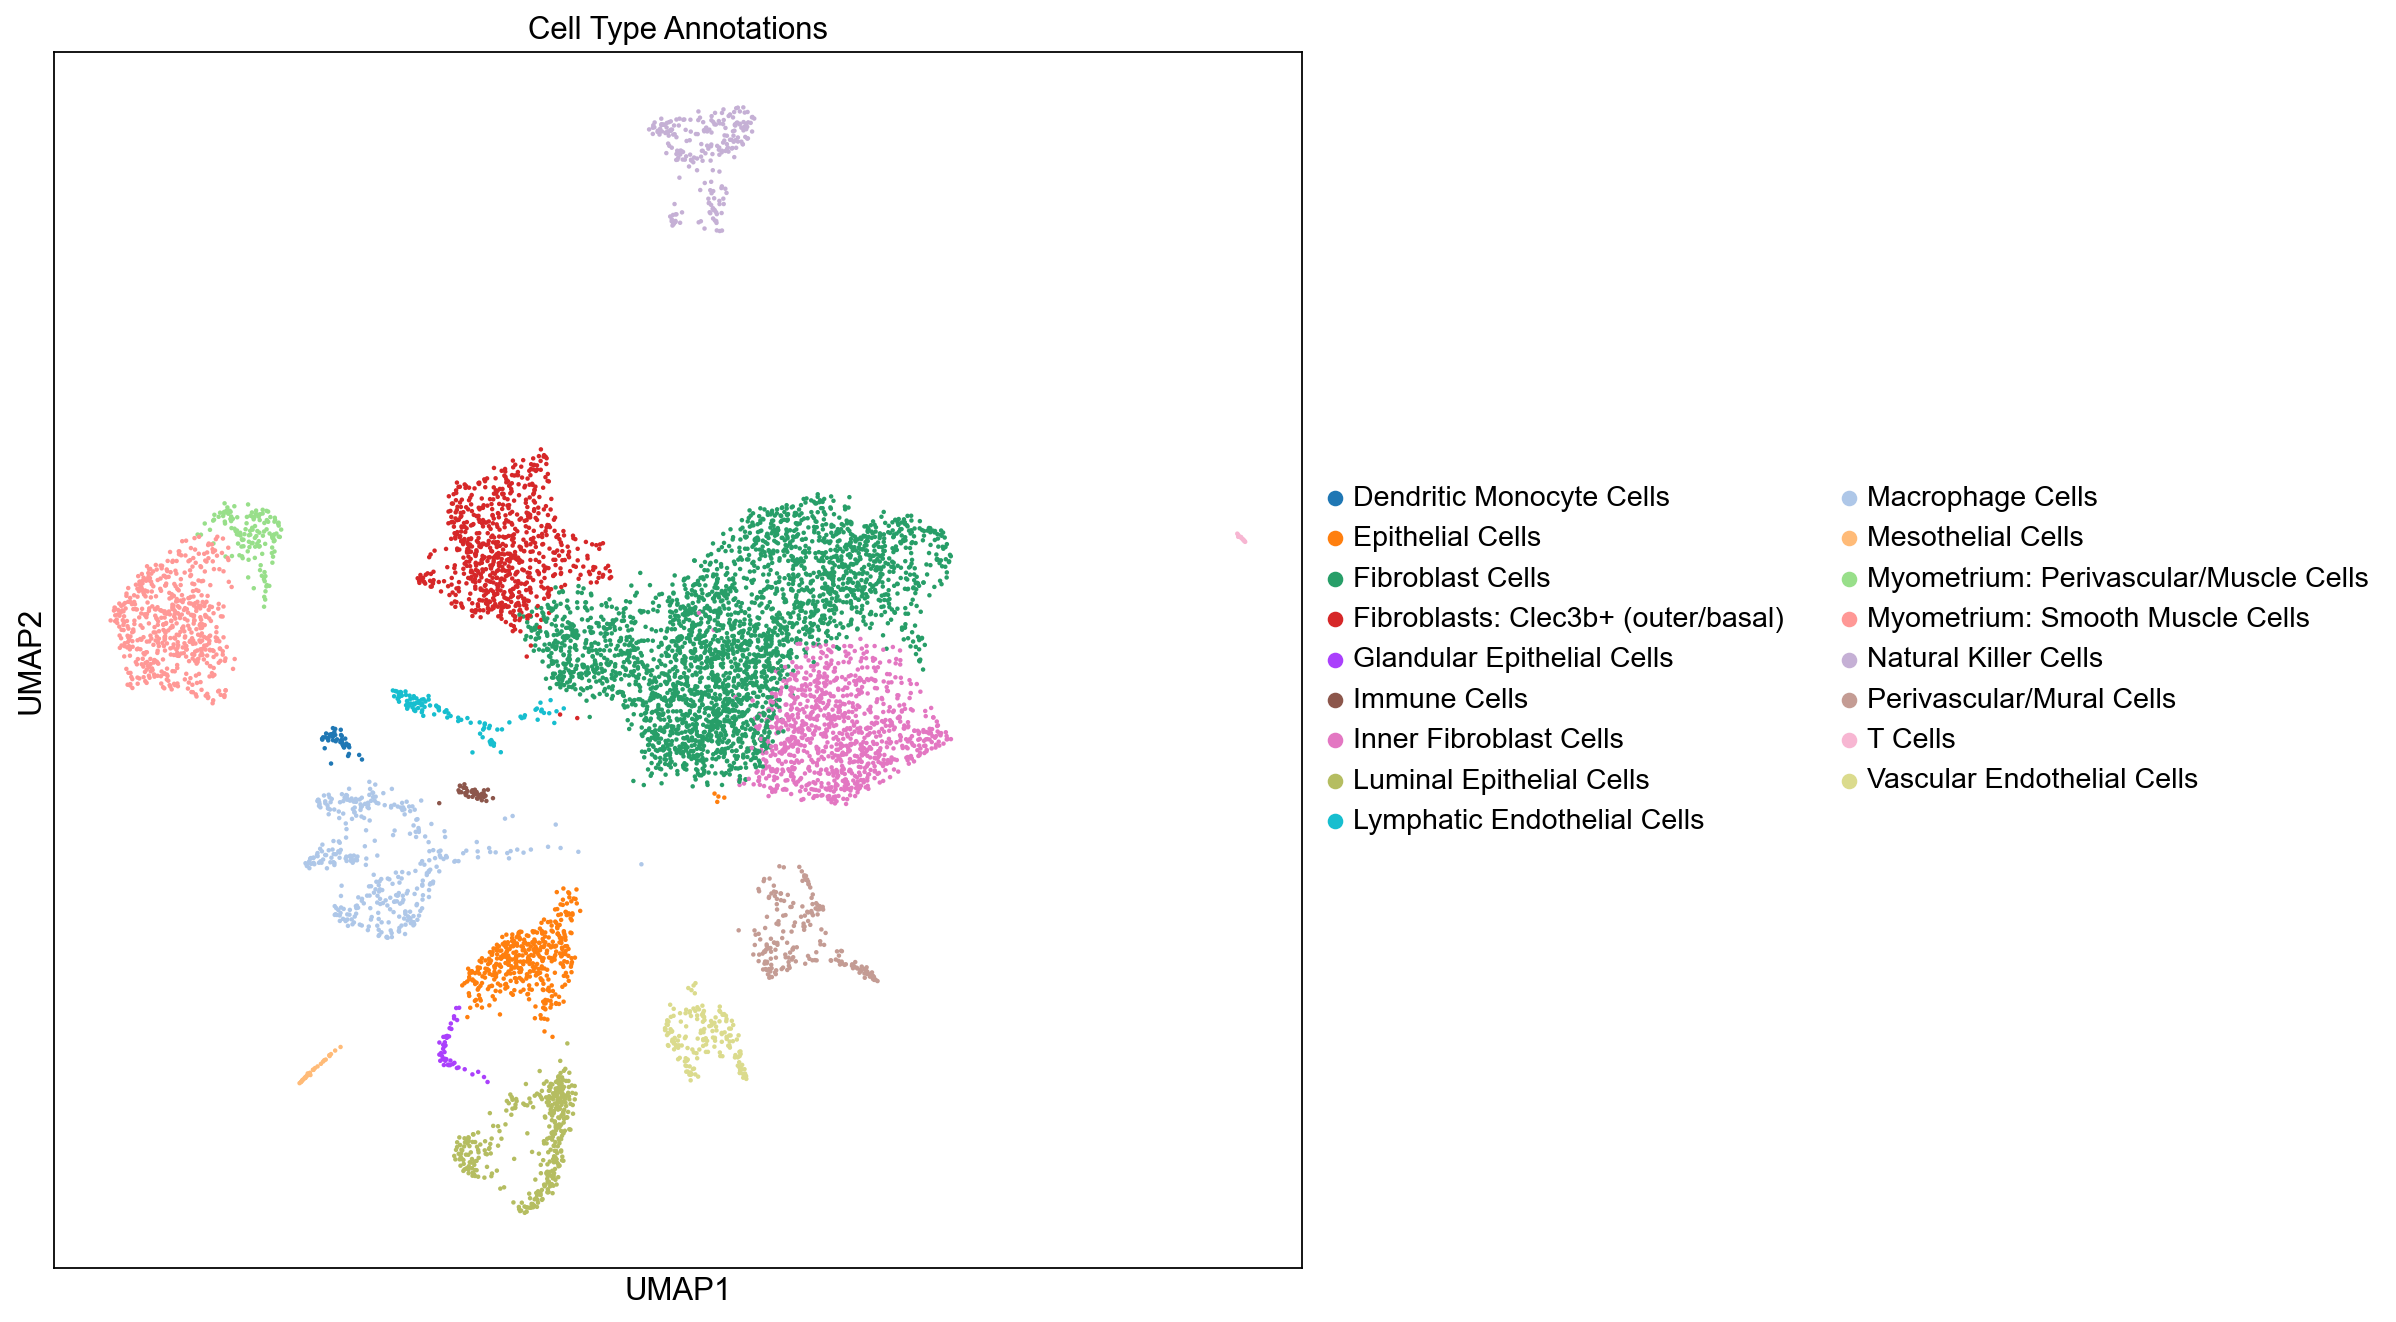

In [ ]:
# Visualise cell types

# Filter out cells marked as 'Ignore' or 'Inconclusive'
adata_filtered = adata[~adata.obs['cell_type'].isin(['Ignore', 'Inconclusive'])].copy()

print(f"Plotting {adata_filtered.n_obs} cells (excluded {adata.n_obs - adata_filtered.n_obs} unassigned cells)")

sc.pl.umap(adata_filtered, color='cell_type', title='Cell Type Annotations')

## Quality Checks

Verify cell type annotations with QC metrics.

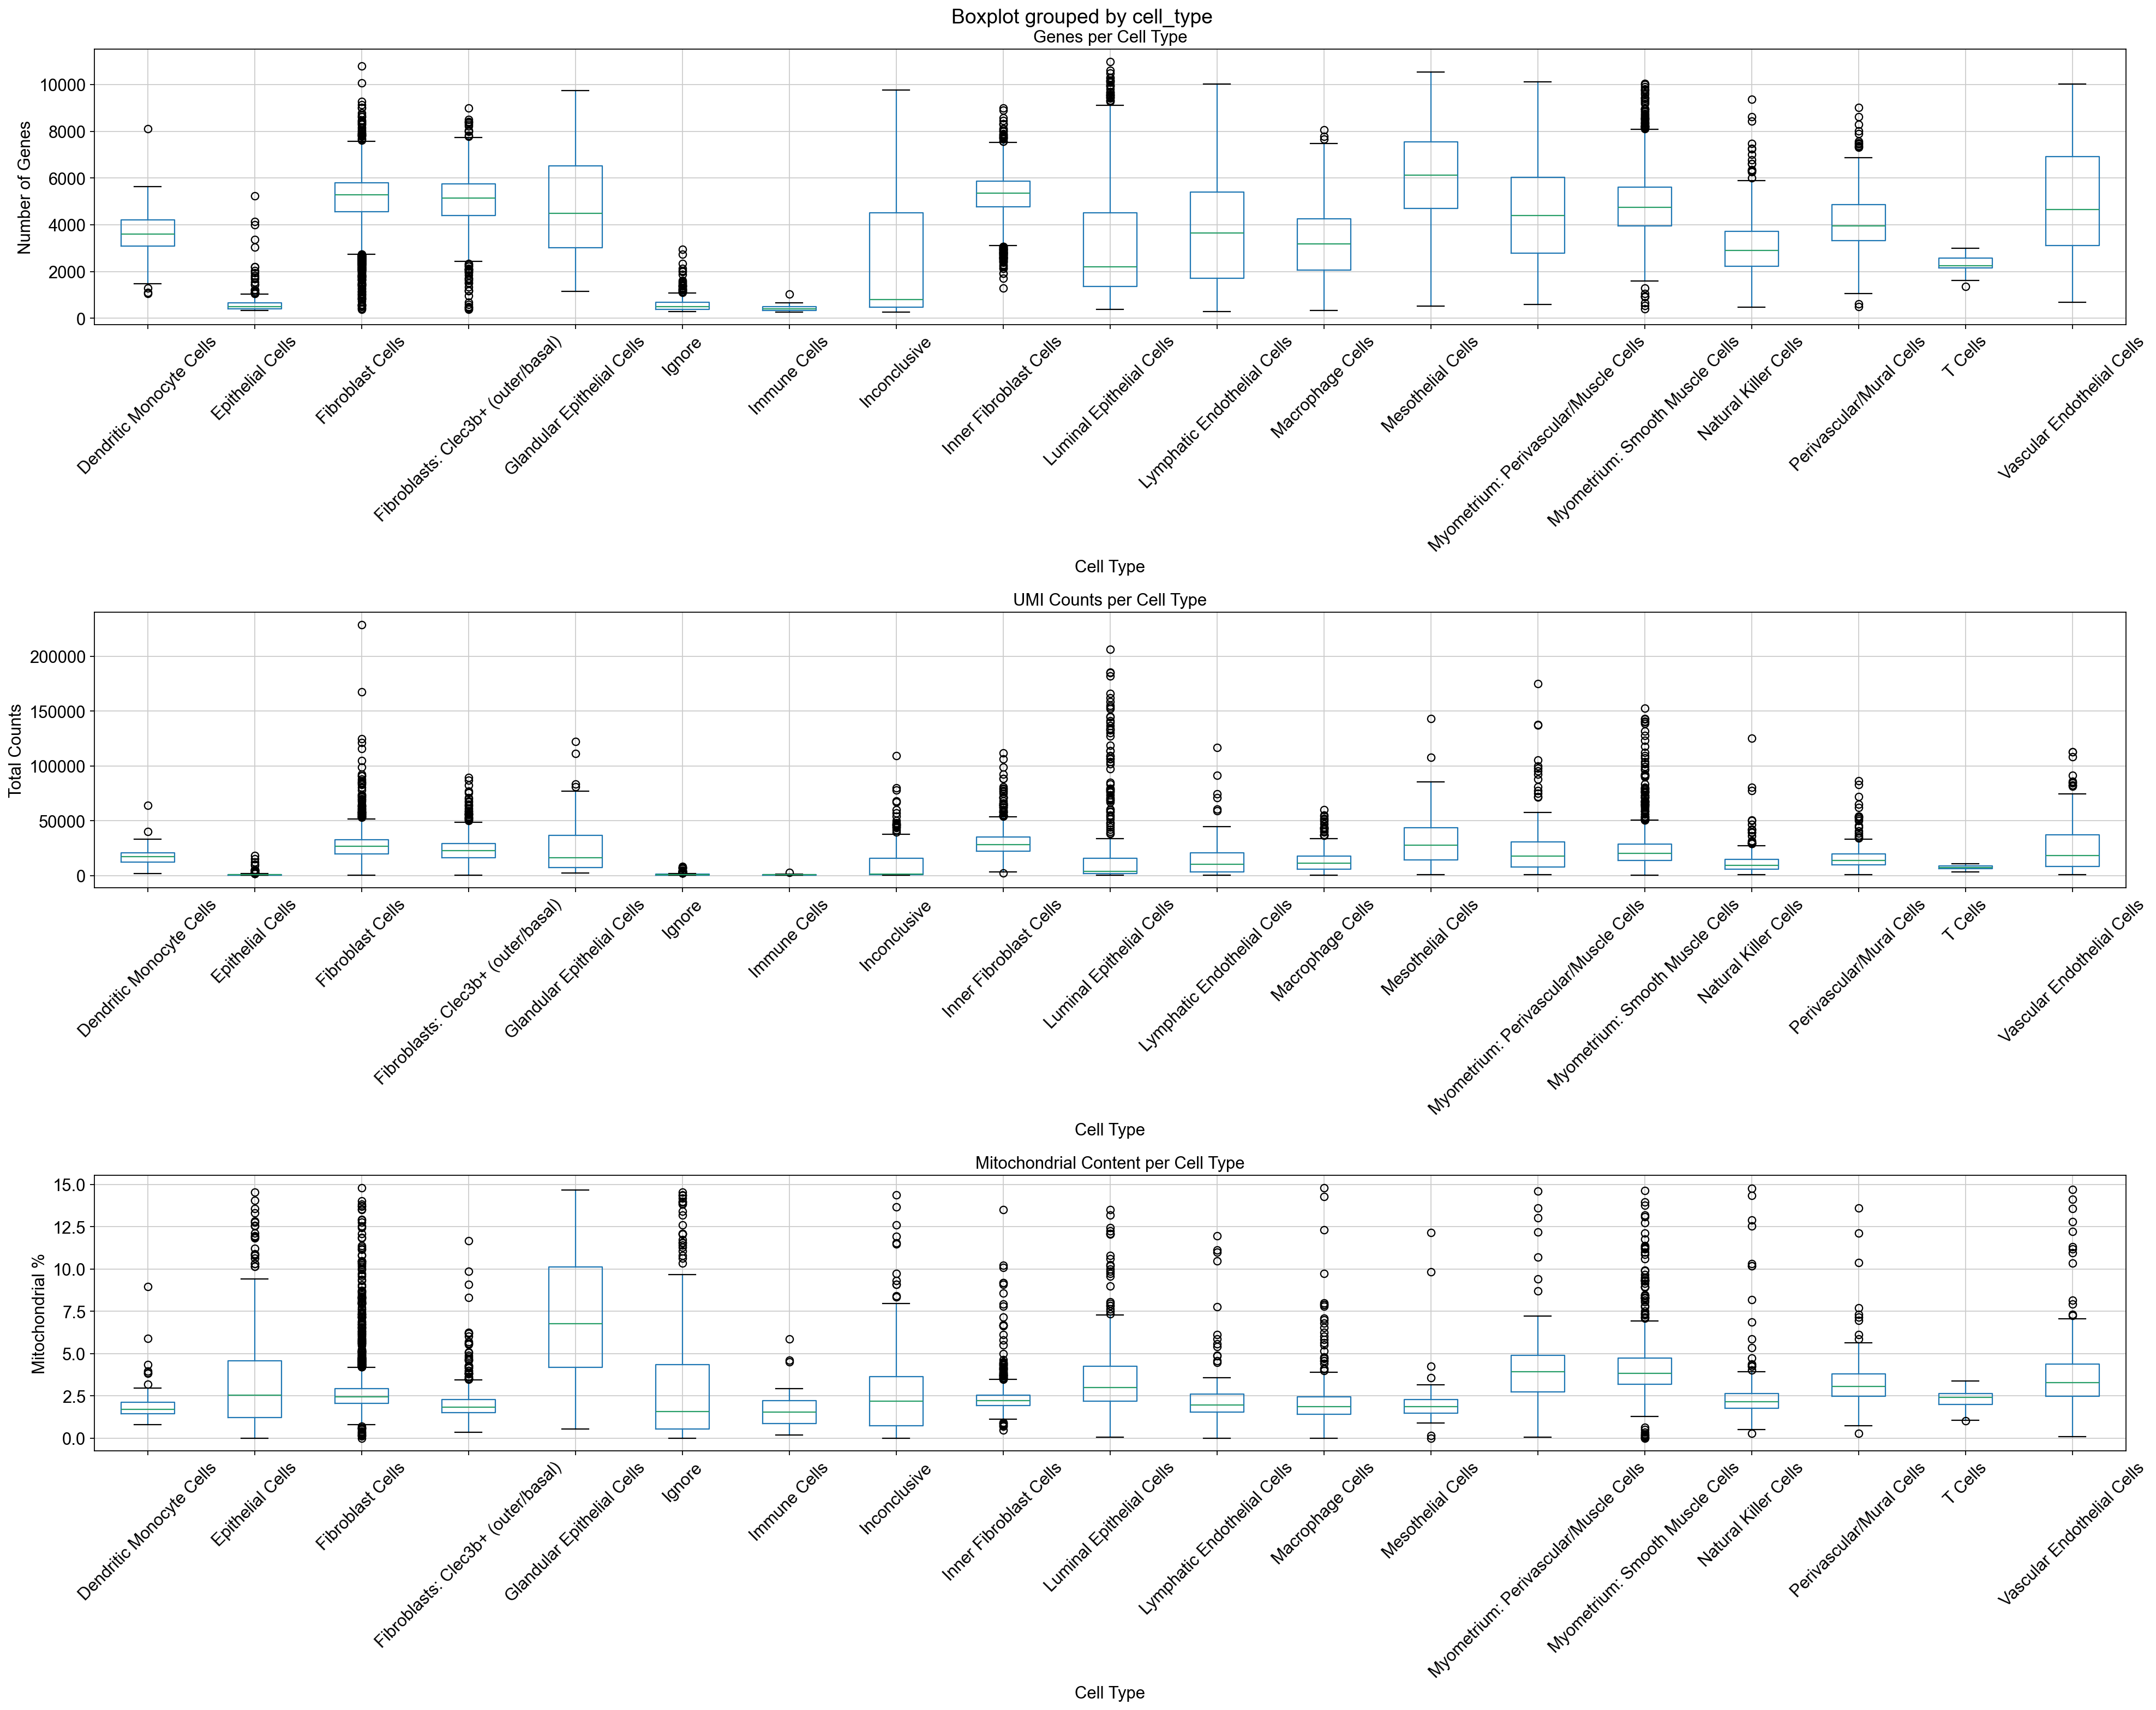

In [27]:
# Compare QC metrics across cell types
fig, axes = plt.subplots(3, 1, figsize=(25, 20))

# Number of genes
adata.obs.boxplot('n_genes_by_counts', by='cell_type', ax=axes[0])
axes[0].set_xlabel('Cell Type')
axes[0].set_ylabel('Number of Genes')
axes[0].set_title('Genes per Cell Type')
axes[0].tick_params(axis='x', rotation=45)

# Total counts
adata.obs.boxplot('total_counts', by='cell_type', ax=axes[1])
axes[1].set_xlabel('Cell Type')
axes[1].set_ylabel('Total Counts')
axes[1].set_title('UMI Counts per Cell Type')
axes[1].tick_params(axis='x', rotation=45)

# Mitochondrial percentage
adata.obs.boxplot('pct_counts_mt', by='cell_type', ax=axes[2])
axes[2].set_xlabel('Cell Type')
axes[2].set_ylabel('Mitochondrial %')
axes[2].set_title('Mitochondrial Content per Cell Type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Save Annotated Data

In [28]:
# Save annotated data
output_file = '../data/processed/annotated_data.h5ad'
adata.write(output_file, compression='gzip')

print(f"Saved annotated data to {output_file}")
print(f"Dataset: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Cell types: {adata.obs['cell_type'].nunique()}")

Saved annotated data to ../data/processed/annotated_data.h5ad
Dataset: 7840 cells x 23542 genes
Cell types: 19


In [29]:
# Filter genes by those used in scFEA analysis
scfea_genes = pd.read_csv('../data/reference/scFEA_metabolic_genes.csv', header=0).iloc[:, 0].tolist()
print(f"Total scFEA genes in reference: {len(scfea_genes)}")
print(f"First 20 scFEA genes: {scfea_genes[:20]}")

# expr_df_transposed has genes as ROWS (index), cells as COLUMNS
print(f"\nExpression matrix structure:")
print(f"  Shape: {expr_df_transposed.shape}")
print(f"  Index (genes): {len(expr_df_transposed.index)}")
print(f"  Columns (cells): {len(expr_df_transposed.columns)}")

genes_in_data = [g for g in scfea_genes if g in expr_df_transposed.index]
print(f"\nMatching genes found in expression matrix: {len(genes_in_data)}")

# Filter expression matrix to only include scFEA genes (select rows)
expr_df_filtered = expr_df_transposed.loc[genes_in_data, :].copy()
print(f"\nFiltered expression matrix shape: {expr_df_filtered.shape}")

# Save filtered expression matrix
expr_df_filtered.to_csv('../data/processed/expr_mtx_scFEA_genes.csv')
print("Filtered expression matrix saved to '../data/processed/expr_mtx_scFEA_genes.csv'")

Total scFEA genes in reference: 719
First 20 scFEA genes: ['2410015N17Rik', '2410018C20Rik', '4631427C17Rik', '4732435N03Rik', '4833446K15Rik', 'A030007L17Rik', 'A530050D06Rik', 'Aacs', 'Aadat', 'Aass', 'Abat', 'Abo', 'Acaa1a', 'Acaa1b', 'Acaa2', 'Acaca', 'Acacb', 'Acad8', 'Acadl', 'Acadm']

Expression matrix structure:
  Shape: (23542, 7840)
  Index (genes): 23542
  Columns (cells): 7840

Matching genes found in expression matrix: 612

Filtered expression matrix shape: (612, 7840)
Filtered expression matrix saved to '../data/processed/expr_mtx_scFEA_genes.csv'


## Next Steps

Proceed to notebook `03_flux_estimation.ipynb` for metabolic flux analysis.